In [23]:
# python imports
import os
from tqdm import tqdm

# torch imports
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

# helper functions for computer vision
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets

import argparse

import scipy.io

import matplotlib.pyplot as plt
import numpy as np

In [24]:
# Import MNIST

from torchvision.datasets import EMNIST
#torchvision.datasets.EMNIST()
# Download and Save MNIST 
digits_train = EMNIST( './emnist_data', train=True, split="digits", download=True, transform = transforms.Compose([transforms.ToTensor(),transforms.RandomCrop(size = 32, padding = 2, fill=0)]))
letters_train = EMNIST( './emnist_data', train=True, split="letters", download=True, transform = transforms.Compose([transforms.ToTensor(),transforms.RandomCrop(size = 32, padding = 2, fill=0)]))
letters_train.targets += 9

digits_test = EMNIST( './emnist_data', train=False, split="digits", download=True, transform = transforms.Compose([transforms.ToTensor(),transforms.RandomCrop(size = 32, padding = 2, fill=0)]))
letters_test = EMNIST( './emnist_data', train=False, split="letters", download=True, transform = transforms.Compose([transforms.ToTensor(),transforms.RandomCrop(size = 32, padding = 2, fill=0)]))
letters_test.targets += 9

comb_train = torch.utils.data.ConcatDataset([digits_train,letters_train])
comb_test = torch.utils.data.ConcatDataset([digits_test,letters_test])

data_train = torch.utils.data.DataLoader(comb_train , batch_size=128,shuffle=True )

data_test = torch.utils.data.DataLoader( comb_test , batch_size=128,shuffle=True )
#for batch_idx, samples in enumerate(data_train):
    #print(batch_idx, samples)

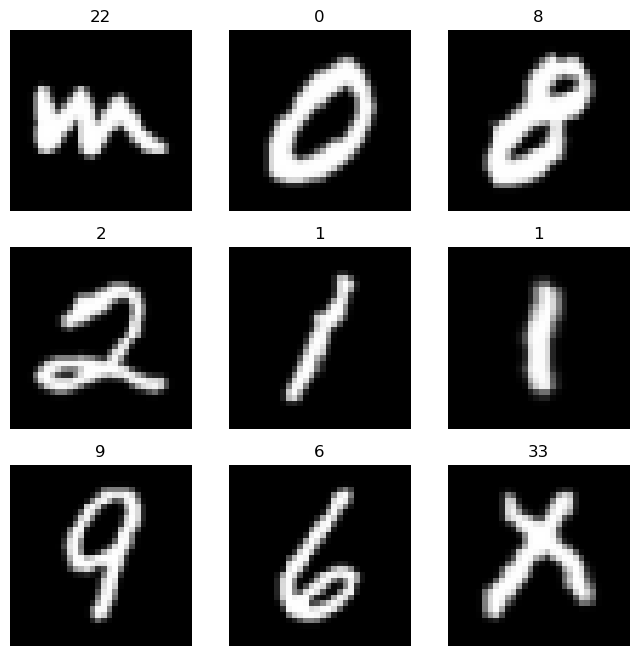

In [25]:
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(comb_test), size=(1,)).item()
    img, label = comb_test[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(label)
    plt.axis("off")
    plt.imshow(img.squeeze().T, cmap="gray")
plt.show()

In [26]:
class LeNet(nn.Module):
    def __init__(self, input_shape=(32, 32), num_classes=36):
        super(LeNet, self).__init__()
        # certain definitions
        self.num_classes = num_classes
        self.input_shape = input_shape
        self.conv1 = nn.Conv2d(1,6,5)
        self.conv2 = nn.Conv2d(6,16,5)
        self.lin1 = nn.Linear(400,120)
        #self.lin1 = nn.Linear(1024,120)
        self.lin2 = nn.Linear(120,84)
        self.lin3 = nn.Linear(84,num_classes)
        
    def forward(self, x):
        shape_dict = {}
        # certain operations
        #Layer1
        x = F.max_pool2d(F.relu(self.conv1(x)),kernel_size=2,stride=2)
        shape_dict[1] = list(x.size())
        #Layer2
        x = F.max_pool2d(F.relu(self.conv2(x)),kernel_size=2,stride=2)
        shape_dict[2] = list(x.size())
        #Layer3
        x = torch.flatten(x,1)
        shape_dict[3] = list(x.size())
        #Layer4
        x = F.relu(self.lin1(x))
        shape_dict[4] = list(x.size())
        #Layer5
        x = F.relu(self.lin2(x))
        shape_dict[5] = list(x.size())
        #Layer6
        out = self.lin3(x)
        shape_dict[6] = list(out.size())
        return out, shape_dict


def count_model_params():
    '''
    return the number of trainable parameters of LeNet.
    '''
    model = LeNet()
    model_params = 0.0
    for name, param in model.named_parameters():
        temp_result = 1
        for each in param.size():
            temp_result = temp_result*each
        model_params += temp_result
    return model_params/1000000


def train_model(model, train_loader, optimizer, criterion, epoch):
    """
    model (torch.nn.module): The model created to train
    train_loader (pytorch data loader): Training data loader
    optimizer (optimizer.*): A instance of some sort of optimizer, usually SGD
    criterion (nn.CrossEntropyLoss) : Loss function used to train the network
    epoch (int): Current epoch number
    """
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)
    model.train()
    train_loss = 0.0
    
    for input, target in tqdm(train_loader, total=len(train_loader)):
        ###################################
        # fill in the standard training loop of forward pass,
        # backward pass, loss computation and optimizer step
        ###################################
        #might want to fix later TODO
        input = input.to(device)
        target = target.to(device)
        
        # 1) zero the parameter gradients
        optimizer.zero_grad()
        # 2) forward + backward + optimize
        output, _ = model(input)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()

        # Update the train_loss variable
        # .item() detaches the node from the computational graph
        # Uncomment the below line after you fill block 1 and 2
        train_loss += loss.item()

    train_loss /= len(train_loader)
    print('[Training set] Epoch: {:d}, Average loss: {:.4f}'.format(epoch+1, train_loss))

    return train_loss


def test_model(model, test_loader, epoch):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)
    model.eval()
    correct = 0
    with torch.no_grad():
        for input, target in test_loader:
            input = input.to(device)
            target = target.to(device)
            output, _ = model(input)
            pred = output.max(1, keepdim=True)[1]
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_acc = correct / len(test_loader.dataset)
    print('[Test set] Epoch: {:d}, Accuracy: {:.2f}%\n'.format(
        epoch+1, 100. * test_acc))

    return test_acc


In [27]:
def save_checkpoint(state, is_best,
                    file_folder="./outputs/",
                    filename='checkpoint.pth.tar'):
    """save checkpoint"""
    if not os.path.exists(file_folder):
        os.makedirs(os.path.expanduser(file_folder), exist_ok=True)
    torch.save(state, os.path.join(file_folder, filename))
    if is_best:
        # skip the optimization state
        state.pop('optimizer', None)
        torch.save(state, os.path.join(file_folder, 'model_best.pth.tar'))







In [30]:
class MyArgs:
    resume = False #"./outputs/checkpoint.pth.tar"
    epochs = 20
    lr = 0.002
    batch_size = 128
args = MyArgs()

# main function for training and testing

# set up random seed
#torch.manual_seed(0)

###################################
# setup model, loss and optimizer #
###################################

model = LeNet()

training_criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=args.lr, momentum=0.9)
# optim.Adam(model.parameters(), lr=args.lr)

# set up transforms to transform the PIL Image to tensors
train_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.RandomHorizontalFlip(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

################################
# setup dataset and dataloader #
################################

train_loader = torch.utils.data.DataLoader(comb_train , batch_size=args.batch_size,shuffle=True )
test_loader = torch.utils.data.DataLoader( comb_test , batch_size=args.batch_size,shuffle=True )

################################
# start the training           #
################################
# resume from a previous checkpoint
best_acc = 0.0
start_epoch = 0
if args.resume:
    if os.path.isfile(args.resume):
        print("=> loading checkpoint '{:s}'".format(args.resume))
        checkpoint = torch.load(args.resume)
        start_epoch = checkpoint['epoch']
        best_acc = checkpoint['best_acc']
        # load model weight
        model.load_state_dict(checkpoint['state_dict'])
        # load optimizer states
        optimizer.load_state_dict(checkpoint['optimizer'])
        print("=> loaded checkpoint '{:s}' (epoch {:d}, acc {:0.2f})".format(
            args.resume, checkpoint['epoch'], 100*best_acc))
    else:
        print("=> no checkpoint found at '{}'".format(args.resume))

# training of the model
print("Training the model ...\n")
for epoch in range(start_epoch, args.epochs):
    # train model for 1 epoch
    train_model(model, train_loader, optimizer, training_criterion, epoch)
    # evaluate the model on test_set after this epoch
    acc = test_model(model, test_loader, epoch)
    # save the current checkpoint
    save_checkpoint({
        'epoch': epoch + 1,
        'state_dict': model.state_dict(),
        'best_acc' : max(best_acc, acc),
        'optimizer' : optimizer.state_dict(),
        }, (acc > best_acc))
    best_acc = max(best_acc, acc)
print("Finished Training")

Training the model ...



100%|██████████| 2850/2850 [01:04<00:00, 43.85it/s]


[Training set] Epoch: 1, Average loss: 1.2084
[Test set] Epoch: 1, Accuracy: 83.51%



100%|██████████| 2850/2850 [01:04<00:00, 44.18it/s]


[Training set] Epoch: 2, Average loss: 0.4352
[Test set] Epoch: 2, Accuracy: 88.00%



100%|██████████| 2850/2850 [01:04<00:00, 44.51it/s]


[Training set] Epoch: 3, Average loss: 0.3530
[Test set] Epoch: 3, Accuracy: 89.18%



100%|██████████| 2850/2850 [01:04<00:00, 44.42it/s]


[Training set] Epoch: 4, Average loss: 0.3159
[Test set] Epoch: 4, Accuracy: 90.03%



100%|██████████| 2850/2850 [01:04<00:00, 44.42it/s]


[Training set] Epoch: 5, Average loss: 0.2930
[Test set] Epoch: 5, Accuracy: 90.34%



100%|██████████| 2850/2850 [01:04<00:00, 44.16it/s]


[Training set] Epoch: 6, Average loss: 0.2776
[Test set] Epoch: 6, Accuracy: 91.19%



100%|██████████| 2850/2850 [01:04<00:00, 44.37it/s]


[Training set] Epoch: 7, Average loss: 0.2663
[Test set] Epoch: 7, Accuracy: 91.23%



100%|██████████| 2850/2850 [01:04<00:00, 44.10it/s]


[Training set] Epoch: 8, Average loss: 0.2564
[Test set] Epoch: 8, Accuracy: 91.38%



100%|██████████| 2850/2850 [01:04<00:00, 43.99it/s]


[Training set] Epoch: 9, Average loss: 0.2492
[Test set] Epoch: 9, Accuracy: 91.51%



100%|██████████| 2850/2850 [01:04<00:00, 44.19it/s]


[Training set] Epoch: 10, Average loss: 0.2436
[Test set] Epoch: 10, Accuracy: 91.71%



100%|██████████| 2850/2850 [01:04<00:00, 44.11it/s]


[Training set] Epoch: 11, Average loss: 0.2378
[Test set] Epoch: 11, Accuracy: 91.50%



100%|██████████| 2850/2850 [01:04<00:00, 44.08it/s]


[Training set] Epoch: 12, Average loss: 0.2329
[Test set] Epoch: 12, Accuracy: 91.83%



100%|██████████| 2850/2850 [01:04<00:00, 44.05it/s]


[Training set] Epoch: 13, Average loss: 0.2286
[Test set] Epoch: 13, Accuracy: 91.96%



100%|██████████| 2850/2850 [01:04<00:00, 44.51it/s]


[Training set] Epoch: 14, Average loss: 0.2248
[Test set] Epoch: 14, Accuracy: 92.05%



100%|██████████| 2850/2850 [01:04<00:00, 44.47it/s]


[Training set] Epoch: 15, Average loss: 0.2214
[Test set] Epoch: 15, Accuracy: 91.86%



100%|██████████| 2850/2850 [01:04<00:00, 44.31it/s]


[Training set] Epoch: 16, Average loss: 0.2181
[Test set] Epoch: 16, Accuracy: 92.28%



100%|██████████| 2850/2850 [01:03<00:00, 44.93it/s]


[Training set] Epoch: 17, Average loss: 0.2152
[Test set] Epoch: 17, Accuracy: 92.07%



100%|██████████| 2850/2850 [01:03<00:00, 44.63it/s]


[Training set] Epoch: 18, Average loss: 0.2128
[Test set] Epoch: 18, Accuracy: 92.13%



100%|██████████| 2850/2850 [01:03<00:00, 44.66it/s]


[Training set] Epoch: 19, Average loss: 0.2101
[Test set] Epoch: 19, Accuracy: 92.40%



100%|██████████| 2850/2850 [01:04<00:00, 44.45it/s]


[Training set] Epoch: 20, Average loss: 0.2073
[Test set] Epoch: 20, Accuracy: 92.06%

Finished Training


In [29]:
model

LeNet(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (lin1): Linear(in_features=400, out_features=120, bias=True)
  (lin2): Linear(in_features=120, out_features=84, bias=True)
  (lin3): Linear(in_features=84, out_features=36, bias=True)
)

In [105]:
count_model_params() *1000000

61706.0